In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset_path = '/content/drive/MyDrive/Cats and Dogs'
img_size = (224, 224)
batch_size = 32
seed = 42

In [3]:
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    shuffle=True
)

Found 140 files belonging to 2 classes.


In [4]:
dataset_size = len(full_ds)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)

In [5]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
])

In [6]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

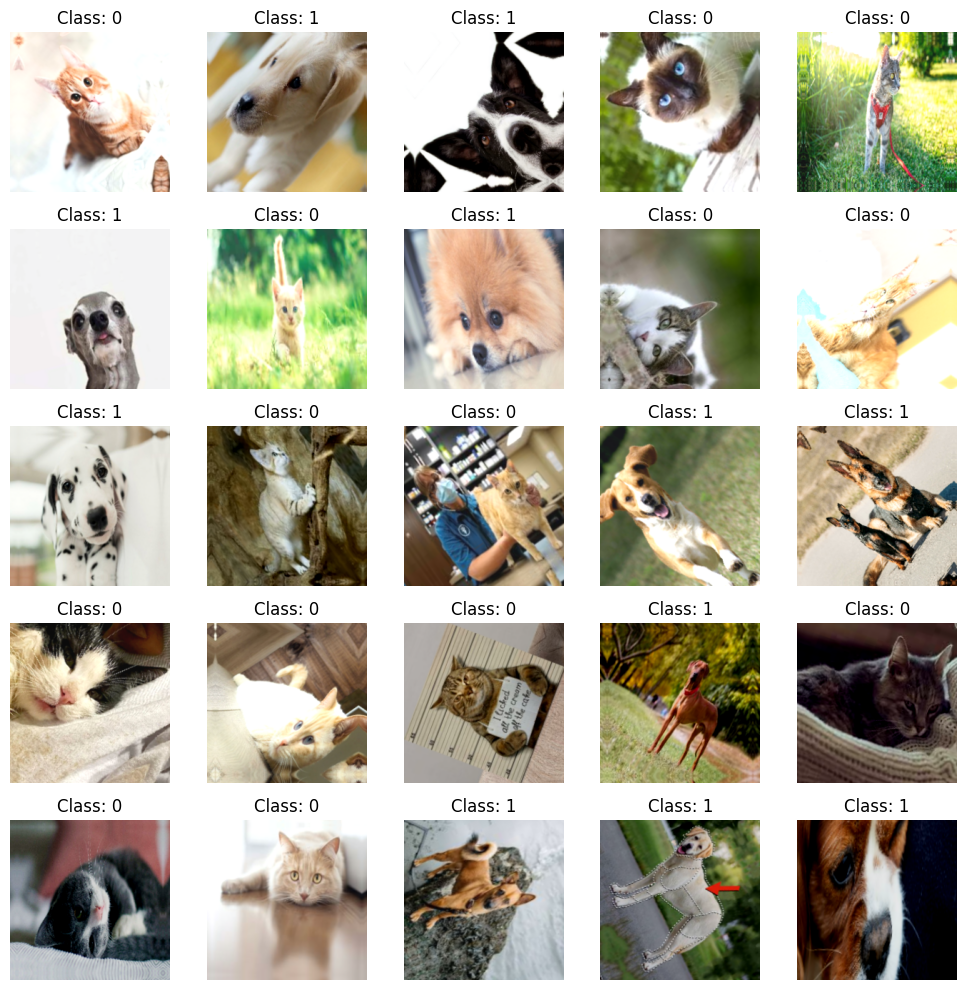

In [7]:
image_batch, label_batch = next(iter(augmented_train_ds))
num_images_to_display = 25
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(num_images_to_display):
    ax = axes[i // 5, i % 5]
    ax.imshow(image_batch[i].numpy().astype("uint8"))
    ax.set_title(f"Class: {label_batch[i].numpy()}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [9]:
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3), name='input_layer'),
    Rescaling(1./255),
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    MaxPooling2D((3, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])

In [10]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 451,410 (1.72 MB)

 Trainable params: 451,410 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(augmented_train_ds, epochs=10)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.5125 - loss: 0.7213
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 595ms/step - accuracy: 0.4563 - loss: 0.7000
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.5271 - loss: 0.6941
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step - accuracy: 0.4802 - loss: 0.6926
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.4906 - loss: 0.6931
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - accuracy: 0.5219 - loss: 0.6923
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.5135 - loss: 0.6920
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.5667 - loss: 0.6910
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 365ms/step - accuracy: 0.5125 - loss: 0.6932
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.5469 - loss: 0.6910


In [13]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - loss: 0.6771
Test Accuracy: 0.75
